In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, T5Tokenizer, T5EncoderModel
import torch
import re
import json
import numpy as np
import sys

## Negative Samples Creation w/ Embeddings and Coisne Similarity

Here we chose the approach to create embeddings from the prot_t5_xl model and then check if the embedding is in a certain "un-similarity range" which is a self-defined threshold. This becuase evaluations showed that this is (at least as far as we consider) the "best" approach.

In [2]:
read_path_beta = "../../data/customDatasets/paired_concatenated.tsv"
paired_df = pd.read_csv(read_path_beta, sep="\t")

In [3]:
paired_df

,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,...,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
1,2,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
2,3,TRAV2*01,NaN,CCAVKASGSRLTF,TRBV13*01,TRBJ1-5*01,CASSYEPGQVSHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
3,4,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
4,5,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEQGGL,2.0,HLA-B*08,B2M,MHCI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29903,29904,TRAV25,TRAJ28,CAGSGAGSYQLTF,NaN,NaN,CASSLEGQASSYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,CLGGLLTMV,NaN,NaN,NaN,NaN,1
29904,29905,TRAV25,TRAJ28,CAGLGAGSYQLTF,NaN,NaN,CASSLEGQGASYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,CLGGLLTMV,NaN,NaN,NaN,NaN,1
29905,29906,TRAV17*01,TRAJ11*01,CATEGNSGYSTLTF,NaN,NaN,CASSSQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLYALALLL,NaN,NaN,NaN,NaN,1
29906,29907,TRAV17*01,TRAJ11*01,CATEGDSGYSTLTF,NaN,NaN,CASSYQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLYALALLL,NaN,NaN,NaN,NaN,1


In [4]:
len(set(paired_df["Epitope"]))

1107

         Epitope  count
0      KLGGALQAK  13892
1      GILGFVFTL   2501
2     AVFDRKSDAK   1754
3       RAKFKQLL   1221
4      IVTDFSVIK    723
...          ...    ...
1102   MPNMLRIMA      1
1103   FPDLNGDVV      1
1104   FPFTSFGPL      1
1105   RTAPHGHEL      1
1106   YTDINGNLH      1

[1107 rows x 2 columns]


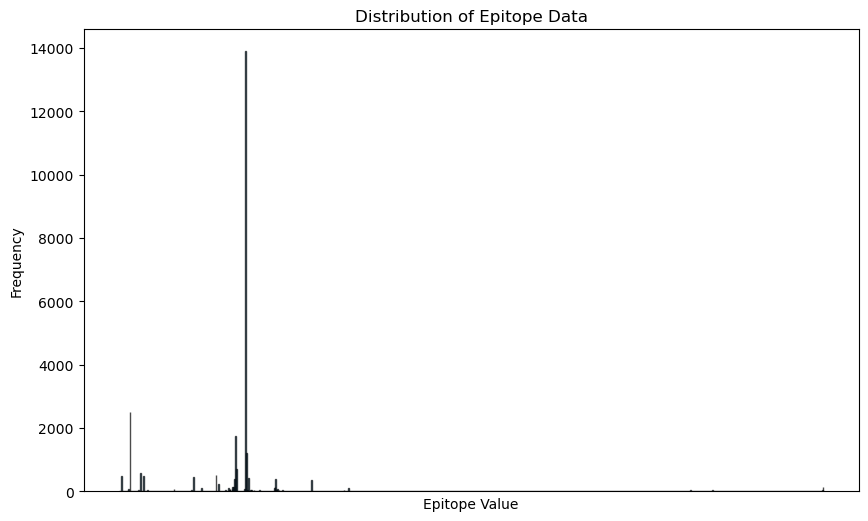

In [5]:
paired_df['Epitope'] = paired_df['Epitope'].astype(str)
epitope_counts = paired_df['Epitope'].value_counts().reset_index()
print(epitope_counts)
epitope_counts.columns = ['Epitope Name', 'Count'] 

plt.figure(figsize=(10, 6))
plt.hist(paired_df['Epitope'], bins=len(epitope_counts), edgecolor='k', alpha=0.7)
plt.xlabel('Epitope Value')
plt.ylabel('Frequency')
plt.title('Distribution of Epitope Data')
plt.xticks([])  # removes the x-axis labels
plt.show()

In [6]:
# print(epitope_counts.to_string())

In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))


Using device: cpu


In [8]:
'''
#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50 in half-precision)
transformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link)
if device==torch.device("cpu"):
  print("Casting model to full precision for running on CPU ...")
  model.to(torch.float32) # only cast to full-precision if no GPU is available
model = model.to(device)
model = model.eval()
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False, legacy=True)
'''

Loading: Rostlab/prot_t5_xl_half_uniref50-enc
Casting model to full precision for running on CPU ...


In [9]:
epitopes = set(paired_df["Epitope"].to_list())

In [10]:
# this will replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
processed_epitopes = [(sequence, " ".join(list(re.sub(r"[UZOB]", "X", sequence)))) for sequence in epitopes]
# processed_epitopes

In [11]:
def process_batch(processed_seqs):
    # Extract just the processed sequences for tokenization
    sequences = [seq[1] for seq in processed_seqs]
    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest", return_tensors="pt")
    input_ids = ids['input_ids'].to(device)
    attention_mask = ids['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    last_hidden_states = outputs.last_hidden_state
    
    # Now, return embeddings mapped to the original sequence
    embeddings = {}
    for i, (original_seq, _) in enumerate(processed_seqs):
        seq_len = attention_mask[i].sum().item() - 2  # Subtract [CLS] and [SEP]
        valid_embeddings = last_hidden_states[i, 1:seq_len+1]
        mean_embedding = valid_embeddings.mean(dim=0)
        embeddings[original_seq] = mean_embedding.cpu().numpy()  # Use original sequence as key
    
    return embeddings

In [12]:
to_path = "../../data/customDatasets/negative_samples/temp"
file_name = "Stitchr_paired_concatenated_with_epitope_embedding.tsv"

In [13]:

batch_size = 128
sequence_to_embedding = {}

# Batch processing with a dictionary, using original sequences as keys
for i in range(0, len(processed_epitopes), batch_size):
    batch_sequences = processed_epitopes[i:i+batch_size]
    batch_embeddings = process_batch(batch_sequences)
    sequence_to_embedding.update(batch_embeddings)

    paired_df["Epitope Embedding"] = paired_df["Epitope"].map(sequence_to_embedding)

# This is needed becuase the embedding is huge and otherwise it would be stored with line breaks (\n) 
# This would make it difficult while reading the file
paired_df['Epitope Embedding'] = paired_df['Epitope Embedding'].apply(lambda x: json.dumps(x.tolist()))

paired_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)



The cell above is commented out to safe time. After changing something in the underlaying dataset re-run this cell to create the up-to-date embeddings!

In [14]:

paired_df = pd.read_csv(to_path+"/"+file_name, sep="\t")
paired_df['Epitope Embedding'] = paired_df['Epitope Embedding'].apply(lambda x: np.array(json.loads(x)))

In [15]:
max_index = len(paired_df) - 1 
negative_epitopes_cosine = []

In [16]:
def cosine_similarity(embedding1, embedding2): 
    cosine = np.dot(embedding1,embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    return cosine

In [17]:
def is_valid_negative(cosine_similarity, current_epitope, random_epitope): 
    is_valid = False
    cosine_min = -0.75
    cosine_max = 0.75

    if (cosine_similarity >= cosine_min \
        and cosine_similarity <= cosine_max) \
        and (current_epitope != random_epitope): 
        is_valid = True 

    return is_valid


In [18]:
sys_max_depth = sys.getrecursionlimit()
max_attempts_by_system = sys_max_depth - 1

In [19]:
len(paired_df["Epitope"])

29908

In [20]:
def search_negative_epitope_embedding(df, index, current_epitope, max_attempts=max_attempts_by_system):
    current_embedding = df["Epitope Embedding"][index]
    attempt = 0
    
    while attempt < max_attempts:
        random_epitope_index = np.random.randint(0, len(df))
        random_epitope = df["Epitope"][random_epitope_index]
        
        if random_epitope_index == index:
            attempt += 1
            continue  # Skip the rest of the loop and try again
        
        random_epitope_embedding = df["Epitope Embedding"][random_epitope_index]
        cosine = cosine_similarity(current_embedding, random_epitope_embedding)
        
        if is_valid_negative(cosine, current_epitope, random_epitope) or attempt == max_attempts - 1:
            return random_epitope  # Return the found valid or last attempt epitope
        
        attempt += 1
    
    # This point should theoretically never be reached because of the check in the loop,
    # but it's a fallback to return a random different epitope if for some reason it does.
    while True:
        random_epitope_index = np.random.randint(0, len(df))
        if random_epitope_index != index:
            return df["Epitope"][random_epitope_index]

for i, epitope in enumerate(paired_df["Epitope"]):
    negative_epitope = search_negative_epitope_embedding(paired_df, i, epitope)
    negative_epitopes_cosine.append(negative_epitope)


In [21]:
len((negative_epitopes_cosine))

29908

In [22]:
negative_epitopes_cosine_dict = {"Negative Epitope": negative_epitopes_cosine}
negative_epitopes_cosine_df = pd.DataFrame(negative_epitopes_cosine_dict)
# print(negative_epitopes_cosine_df.to_string())
negative_epitopes_cosine_df

,Negative Epitope
0,LLFGMPPCL
1,KLMNIQQQL
2,GILGFVFTL
3,RLVPYLEFL
4,PFPQPELPY
...,...
29903,RLRAEAQVK
29904,KQIYKTPPI
29905,KLGGALQAK
29906,KLGGALQAK


    Epitope Name  Count
0      GILGFVFTL   6759
1      KLGGALQAK   4087
2     ELAGIGILTV   1728
3      GLCTLVAML   1609
4     AVFDRKSDAK   1430
..           ...    ...
863    LSDRVVFVL      1
864    KITEHSWNA      1
865    FLPRVFSAV      1
866    MCDVRQLLF      1
867    ESDPIVAQY      1

[868 rows x 2 columns]


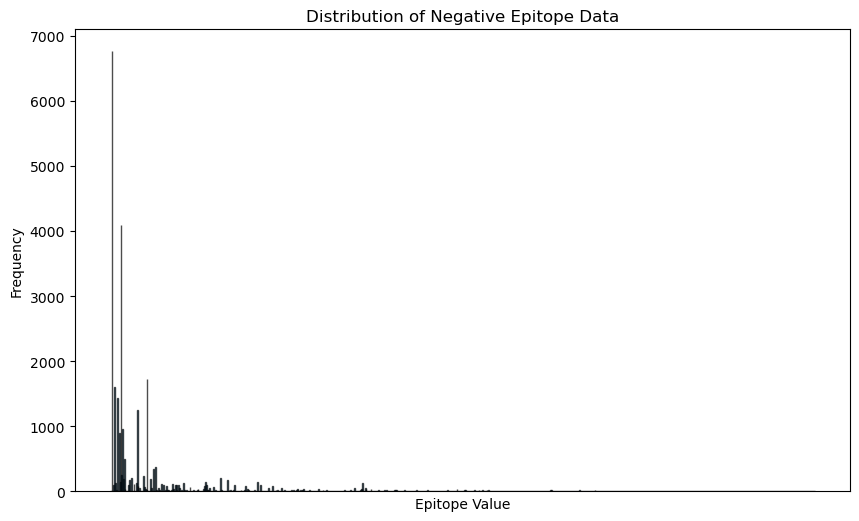

In [23]:
epitope_counts_negative = negative_epitopes_cosine_df['Negative Epitope'].value_counts().reset_index()
epitope_counts_negative.columns = ['Epitope Name', 'Count']
print(epitope_counts_negative) 

plt.figure(figsize=(10, 6))
plt.hist(negative_epitopes_cosine_df['Negative Epitope'].astype(str), bins=len(epitope_counts_negative), edgecolor='k', alpha=0.7)
plt.xlabel('Epitope Value')
plt.ylabel('Frequency')
plt.title('Distribution of Negative Epitope Data')
plt.xticks([])  # removes the x-axis labels
plt.show()

In [24]:
paired_df.columns

Index(['TCR_name', 'TRAV', 'TRAJ', 'TRA_CDR3', 'TRBV', 'TRBJ', 'TRB_CDR3',
       'TRAC', 'TRBC', 'TRA_leader', 'TRB_leader', 'Linker', 'Link_order',
       'TRA_5_prime_seq', 'TRA_3_prime_seq', 'TRB_5_prime_seq',
       'TRB_3_prime_seq', 'Epitope', 'Score', 'MHC A', 'MHC B', 'MHC class',
       'Binding', 'Epitope Embedding'],
      dtype='object')

In [25]:
paired_with_negative_df = paired_df.drop(["Epitope Embedding"], axis=1).copy(deep=True)
paired_with_negative_df["Binding"] = 0
paired_with_negative_df["Epitope"] = negative_epitopes_cosine
paired_with_negative_df

,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,...,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,LLFGMPPCL,2.0,HLA-B*08,B2M,MHCI,0
1,2,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,KLMNIQQQL,2.0,HLA-B*08,B2M,MHCI,0
2,3,TRAV2*01,NaN,CCAVKASGSRLTF,TRBV13*01,TRBJ1-5*01,CASSYEPGQVSHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,GILGFVFTL,2.0,HLA-B*08,B2M,MHCI,0
3,4,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RLVPYLEFL,2.0,HLA-B*08,B2M,MHCI,0
4,5,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,PFPQPELPY,2.0,HLA-B*08,B2M,MHCI,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29903,29904,TRAV25,TRAJ28,CAGSGAGSYQLTF,NaN,NaN,CASSLEGQASSYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RLRAEAQVK,NaN,NaN,NaN,NaN,0
29904,29905,TRAV25,TRAJ28,CAGLGAGSYQLTF,NaN,NaN,CASSLEGQGASYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,KQIYKTPPI,NaN,NaN,NaN,NaN,0
29905,29906,TRAV17*01,TRAJ11*01,CATEGNSGYSTLTF,NaN,NaN,CASSSQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,KLGGALQAK,NaN,NaN,NaN,NaN,0
29906,29907,TRAV17*01,TRAJ11*01,CATEGDSGYSTLTF,NaN,NaN,CASSYQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,KLGGALQAK,NaN,NaN,NaN,NaN,0


In [27]:
paired_with_negative_df = pd.concat([paired_df.drop(["Epitope Embedding"], axis=1).copy(deep=True), paired_with_negative_df], axis=0)
paired_with_negative_df["TCR_name"] = range(1, len(paired_with_negative_df)+1)
paired_with_negative_df

,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,...,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
1,2,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
2,3,TRAV2*01,NaN,CCAVKASGSRLTF,TRBV13*01,TRBJ1-5*01,CASSYEPGQVSHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
3,4,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1
4,5,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEQGGL,2.0,HLA-B*08,B2M,MHCI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29903,59812,TRAV25,TRAJ28,CAGSGAGSYQLTF,NaN,NaN,CASSLEGQASSYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RLRAEAQVK,NaN,NaN,NaN,NaN,0
29904,59813,TRAV25,TRAJ28,CAGLGAGSYQLTF,NaN,NaN,CASSLEGQGASYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,KQIYKTPPI,NaN,NaN,NaN,NaN,0
29905,59814,TRAV17*01,TRAJ11*01,CATEGNSGYSTLTF,NaN,NaN,CASSSQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,KLGGALQAK,NaN,NaN,NaN,NaN,0
29906,59815,TRAV17*01,TRAJ11*01,CATEGDSGYSTLTF,NaN,NaN,CASSYQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,KLGGALQAK,NaN,NaN,NaN,NaN,0


In [ ]:
to_path = "../../data/customDatasets/negative_samples/"
file_name = "paired_concatenated_with_negative.tsv"

In [ ]:
paired_with_negative_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)